In [4]:
!pip install optuna

In [5]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# text processing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import optuna

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Reading a TSV file
df = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', sep='\t')

df.columns = ['sentiment', 'text']
df.head()

# Displaying the dataframes
print("TSV DataFrame:")
df

TSV DataFrame:


,sentiment,text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...
...,...,...
13444,4,just got back frm my lame dads house..soooo ha...
13445,0,@nmhrbrtsn they're already dying but I'm maki...
13446,0,I think I'm coming down with either a sinus in...
13447,0,@alexmuller its not but i think the Zune HD will


In [7]:
# Rename sentiment label

lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Positive,"@elephantbird Hey dear, Happy Friday to You A..."
1,Positive,Ughhh layin downnnn Waiting for zeina to co...
2,Negative,"@greeniebach I reckon he'll play, even if he's..."
3,Negative,@vaLewee I know! Saw it on the news!
4,Negative,very sad that http://www.fabchannel.com/ has c...


Text(0.5, 1.0, 'Sentiment Data Distribution')

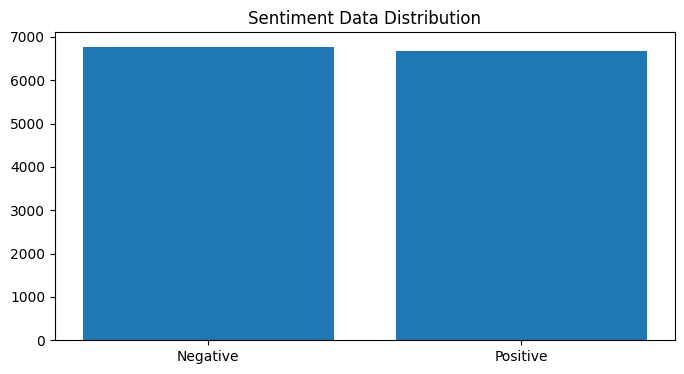

In [8]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [9]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [10]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [11]:
df.text = df.text.apply(lambda x: preprocess(x))

In [12]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [13]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 10759
Test Data size 2690


In [14]:
vectoriser = TfidfVectorizer()
vectoriser.fit_transform(train_data["text"])
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  14658


In [15]:
train_data.head()

,sentiment,text
4556,Positive,wot rubbish weekend deffo staying next weekend...
2457,Negative,yeah never see one
1358,Positive,got onto phone mariaandros smtb looking forwar...
11553,Negative,momentarily depressed stomach ache
12752,Negative,sad sold large camera necklaces lol


In [16]:
X_train = vectoriser.transform(train_data["text"])
X_test  = vectoriser.transform(test_data["text"])


encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)



print(f'Data Transformed.')

Data Transformed.


In [17]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (10759, 14658)
X_test shape: (2690, 14658)


In [18]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (10759, 1)
y_test shape: (2690, 1)


In [19]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

[I 2024-02-24 22:15:40,118] A new study created in memory with name: no-name-608880e8-c1ed-43be-a0c0-b0106a0b6c44
<ipython-input-20-b24c8ec8ac60>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-10, 1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2024-02-24 22:15:40,152] Trial 0 finished with value: 0.6821561338289963 and parameters: {'alpha': 0.0006394675523550855}. Best is trial 0 with value: 0.6821561338289963.
<ipython-input-20-b24c8ec8ac60>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

Best hyperparameters: {'alpha': 0.9819624785209664}
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1396
           1       0.71      0.71      0.71      1294

    accuracy                           0.72      2690
   macro avg       0.72      0.72      0.72      2690
weighted avg       0.72      0.72      0.72      2690



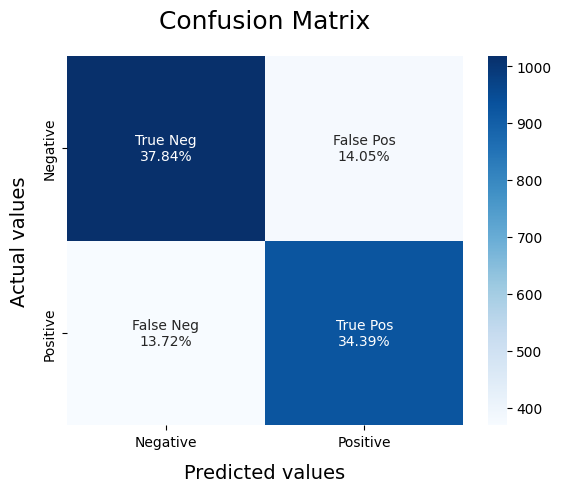

In [20]:
def objective_bernoullinb(trial):
    # Define hyperparameters to search
    alpha = trial.suggest_loguniform('alpha', 1e-10, 1)

    # Initialize model with hyperparameters
    model = BernoulliNB(alpha=alpha)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    classification_report_str = classification_report(y_test, y_pred, output_dict=True)
    accuracy = classification_report_str['accuracy']  # Example metric to optimize

    return accuracy

# Create study object and optimize hyperparameters
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective_bernoullinb, n_trials=100)  # You can adjust n_trials as needed

# Get best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train model with best hyperparameters
best_model_bernoulinb = BernoulliNB(alpha=best_params['alpha'])
best_model_bernoulinb.fit(X_train, y_train)

# Evaluate best model
model_Evaluate(best_model_bernoulinb)

[I 2024-02-24 22:15:45,547] A new study created in memory with name: no-name-5d604b64-ad86-461a-9919-d794dcae2636
<ipython-input-21-a4332cbdbeb5>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 10)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2024-02-24 22:15:45,677] Trial 0 finished with value: 0.7278810408921933 and parameters: {'C': 0.2542986652555157}. Best is trial 0 with value: 0.7278810408921933.
<ipython-input-21-a4332cbdbeb5>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/o

Best hyperparameters: {'C': 0.13433048205103545}
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      1396
           1       0.71      0.75      0.73      1294

    accuracy                           0.73      2690
   macro avg       0.73      0.73      0.73      2690
weighted avg       0.73      0.73      0.73      2690



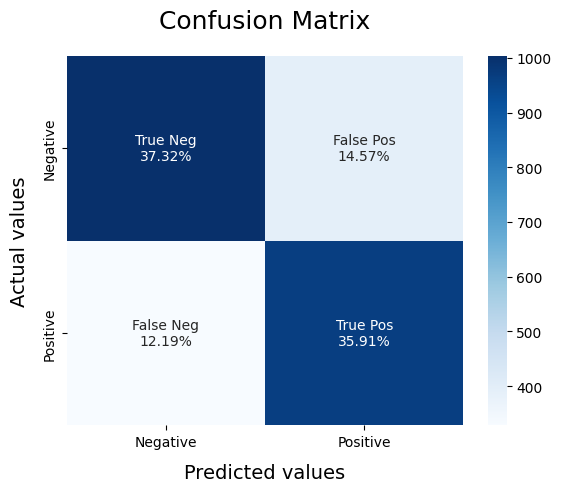

In [21]:
def objective_svc(trial):
    # Define hyperparameters to search
    C = trial.suggest_loguniform('C', 0.1, 10)

    # Initialize model with hyperparameters
    model = LinearSVC(C=C)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    classification_report_str = classification_report(y_test, y_pred, output_dict=True)
    accuracy = classification_report_str['accuracy']  # Example metric to optimize

    return accuracy

# Create study object and optimize hyperparameters
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective_svc, n_trials=100)  # You can adjust n_trials as needed

# Get best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train model with best hyperparameters
best_model_svc = LinearSVC(C=best_params['C'])
best_model_svc.fit(X_train, y_train)

# Evaluate best model
model_Evaluate(best_model_svc)

[I 2024-02-24 22:15:59,773] A new study created in memory with name: no-name-8e17b4b8-af95-49cc-80b5-d51a0a91fe78
<ipython-input-22-8bb4217b27e2>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 10)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2024-02-24 22:16:00,425] Trial 0 finished with value: 0.7230483271375465 and parameters: {'C': 0.1689761659121638, 'max_iter': 859}. Best is trial 0 with value: 0.7230483271375465.
<ipython-input-22-8bb4217b27e2>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

Best hyperparameters: {'C': 1.4443259201897736, 'max_iter': 134}
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      1396
           1       0.71      0.75      0.73      1294

    accuracy                           0.73      2690
   macro avg       0.73      0.73      0.73      2690
weighted avg       0.73      0.73      0.73      2690



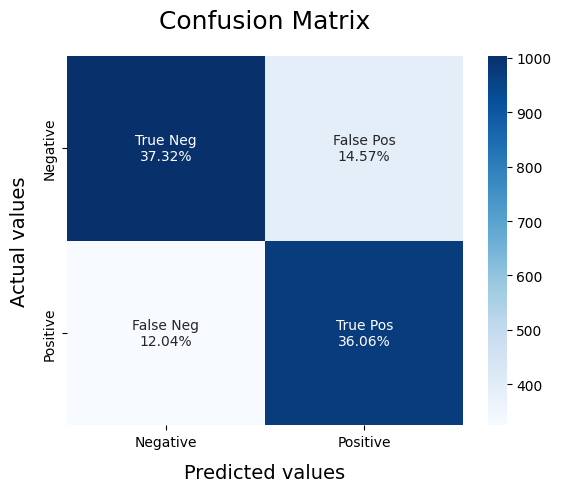

In [22]:
def objective_lr(trial):
    # Define hyperparameters to search
    C = trial.suggest_loguniform('C', 0.1, 10)
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    # Initialize model with hyperparameters
    model = LogisticRegression(C=C, max_iter=max_iter)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    classification_report_str = classification_report(y_test, y_pred, output_dict=True)
    accuracy = classification_report_str['accuracy']  # Example metric to optimize

    return accuracy

# Create study object and optimize hyperparameters
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective_lr, n_trials=100)  # You can adjust n_trials as needed

# Get best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train model with best hyperparameters
best_model_lr = LogisticRegression(C=best_params['C'], max_iter=best_params['max_iter'])
best_model_lr.fit(X_train, y_train)

# Evaluate best model
model_Evaluate(best_model_lr)